This Notebook is for Time Series Prediction for Bitcoin Prices

Dataset is taken from https://www.coindesk.com/price/bitcoin

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os

In [2]:
#Loading the Dataset
#Tell pandas that the first column is datetime
df = pd.read_csv('BTC_USD_2013-10-01_2021-06-02-CoinDesk.csv', parse_dates=['Date'], index_col=['Date']) 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
#Looking at more information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2801 entries, 2013-10-01 to 2021-06-02
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2801 non-null   object 
 1   Closing Price (USD)  2801 non-null   float64
 2   24h Open (USD)       2801 non-null   float64
 3   24h High (USD)       2801 non-null   float64
 4   24h Low (USD)        2801 non-null   float64
dtypes: float64(4), object(1)
memory usage: 131.3+ KB


In [4]:
#Getting only the closing prices for everyday
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


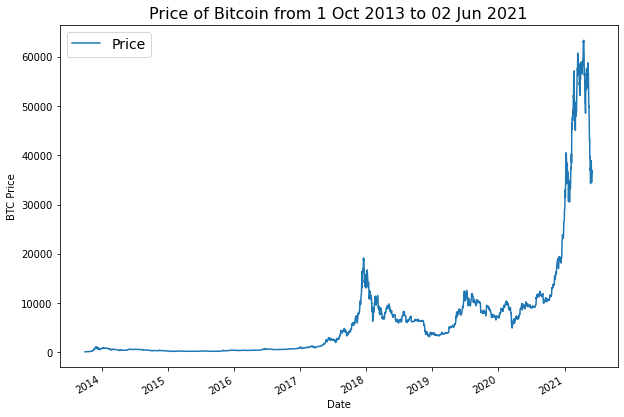

In [5]:
#Plotting all the prices to get a better look
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 02 Jun 2021", fontsize=16)
plt.legend(fontsize=14);

In [6]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [7]:
#Splitting the Dataset into Train and Test set
#In Time-seires problems splitting the dataset the normal way, which is randomly selecting 80-20 split is wrong!
#We aim to train our model on past data and hope it works on the artificial future data
#Thus splitting the dataset the orthodox way makes no sense
#Instead we create the training set as the first 80% samples and the Test set as the remaining 20% as follows


split_size = int(0.8 * len(prices)) # 80% train, 20% test

#Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

#Create Test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

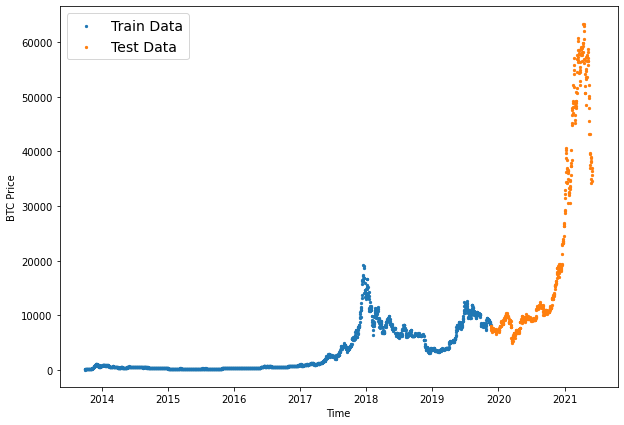

In [8]:
#Plotting the splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);
plt.show()

In [9]:
#Creating a plotting fucntion
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14);
    plt.grid(True)

Naive Model (Baseline)

In [10]:
#creating a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([8118.4885358 , 8074.84317361, 7612.7405735 , 7262.11053495,
       7303.40575852, 7041.73293642, 7211.86180875, 7141.06944869,
       7523.4806726 , 7390.20746923])

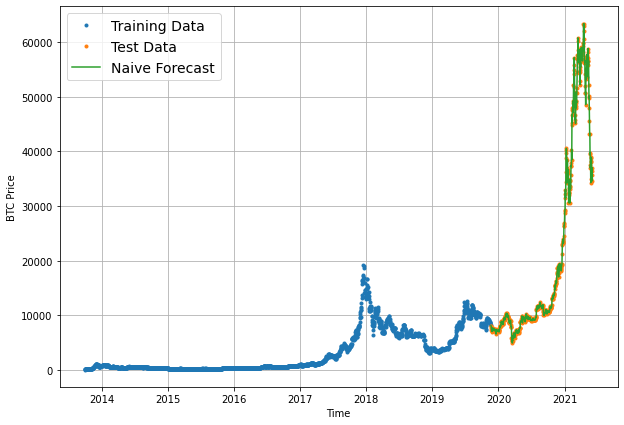

In [11]:
#Plotting the naive Forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, format=".", label='Training Data')
plot_time_series(timesteps=X_test, values=y_test, format=".",  label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast,format="-", label='Naive Forecast')

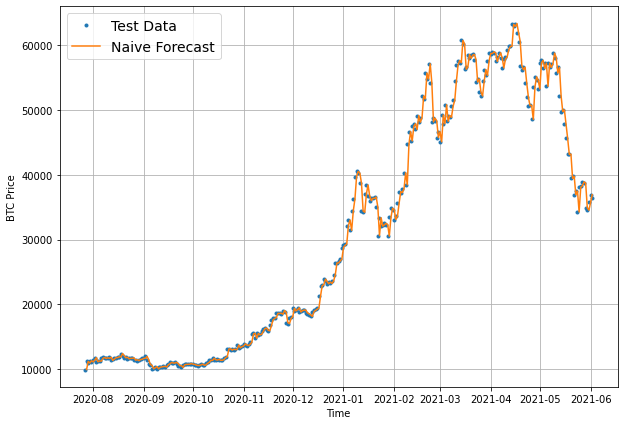

In [12]:
#zooming in on the test and naive forecast
plt.figure(figsize=(10,7))
offset=250
plot_time_series(timesteps=X_test, values=y_test, format=".", start=offset, label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast,format="-", start=offset, label='Naive Forecast')

In [13]:
#Code snippet for MASE 

def mean_absolute_scaled_error(y_true, y_pred):
    #Implement MASE (assuming no seasonality of data)
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

In [62]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    #Calculate different evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    # Account for different sized metrics (for longer horizons, reduce to single number)
    if mae.ndim > 0:
        # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {'mae': mae.numpy(),
           'mse': mse.numpy(),
           'rmse': rmse.numpy(),
           'mape': mape.numpy(),
            'mase': mase.numpy()}

In [15]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 602.0485,
 'mse': 1258207.5,
 'rmse': 1121.6985,
 'mape': 2.5736644,
 'mase': 0.99834347}

In [16]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [17]:
#Function to label windowed data
def get_labelled_windows(x, horizon=1):
    # example Input: [1,2,3,4,5,6] -> output: ([1,2,3,4,5], [6])
    return x[:, :-horizon], x[:, -horizon:]

In [18]:
#function to view numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    #Turns a 1D array into a 2D array of sequential windows of window_size.
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes] # get the original array indexed with windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [19]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2794, 2794)

In [20]:
# Making the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [21]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2235, 559, 2235, 559)

In [22]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [23]:
#saving our best results
def create_model_checkpoint(model_name, save_path="model_experiments"):
      return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [24]:
len(train_windows), len(test_windows), len(full_windows)

(2235, 559, 2794)

In [25]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_1_dense')

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, y=train_labels, epochs=100, verbose=0, batch_size=128, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: mod

In [26]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
#Evaluating model1
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 829us/step - loss: 608.9508


608.9508056640625

In [27]:
#funstion for making forecast
def make_forecast(model, input_data):
    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [28]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds)

559

In [29]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 608.951,
 'mse': 1288094.1,
 'rmse': 1134.9424,
 'mape': 2.6230147,
 'mase': 1.0093668}

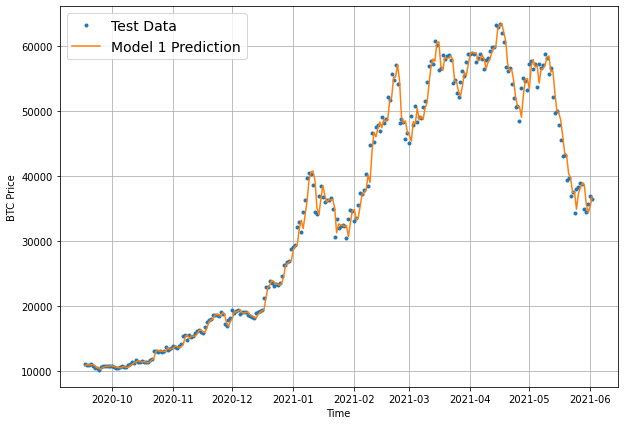

In [30]:
#Plotting model_1 results
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format='.', start=offset, label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds,format='-', start=offset, label='Model 1 Prediction')


In [37]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 30 # use a 30 days worth of timesteps to predict the horizon

In [38]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2771, 2771)

In [39]:
#making train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2216, 555, 2216, 555)

In [41]:
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_2.fit(x=train_windows, y=train_labels, epochs=100, verbose=0, batch_size=128, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [43]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
#Evaluating model1
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 838us/step - loss: 643.7311


643.7311401367188

In [44]:
# Get forecast predictions
model_2_preds = make_forecast(model_2, input_data=test_windows)

In [46]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 643.73114,
 'mse': 1403219.4,
 'rmse': 1184.5756,
 'mape': 2.7877293,
 'mase': 1.0619661}

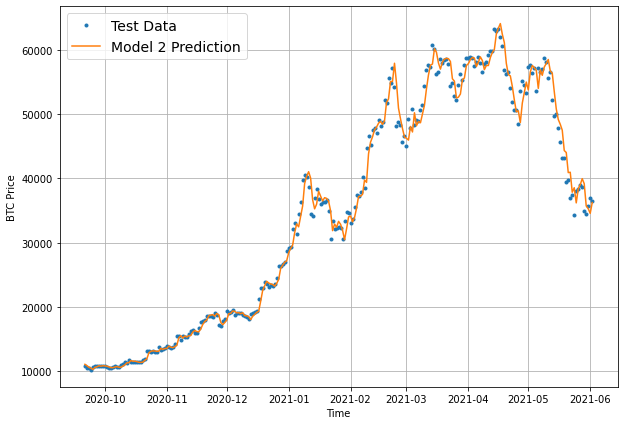

In [47]:
#Plotting model_1 results
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format='.', start=offset, label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds,format='-', start=offset, label='Model 2 Prediction')


Model 3 - Dense model with horizon = 7 and Windows = 30

In [48]:
HORIZON = 7 # predict 7 step at a time
WINDOW_SIZE = 30 # use a 30 days worth of timesteps to predict the horizon

In [49]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2765, 2765)

In [50]:
#making train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2212, 553, 2212, 553)

In [56]:
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_3.fit(x=train_windows, y=train_labels, epochs=100, verbose=0, batch_size=128, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [57]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
#Evaluating model1
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 754us/step - loss: 1390.7767


1390.7767333984375

In [58]:
# Get forecast predictions
model_3_preds = make_forecast(model_3, input_data=test_windows)

In [63]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 1390.7767,
 'mse': 6765924.0,
 'rmse': 1585.8329,
 'mape': 5.8130584,
 'mase': 2.3070545}

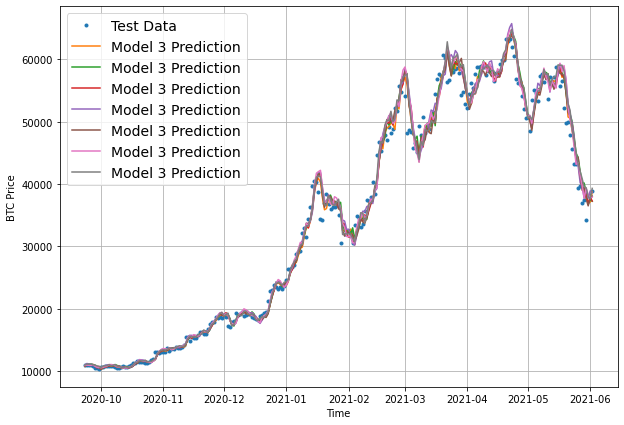

In [64]:
#Plotting model_3 results
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format='.', start=offset, label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,format='-', start=offset, label='Model 3 Prediction')


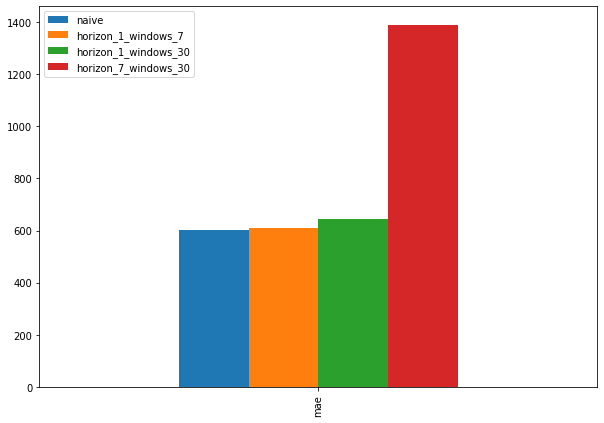

In [65]:
#Comparing our 3 dense models with naive forecast based on mae 
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_windows_7": model_1_results["mae"], 
              "horizon_1_windows_30": model_2_results["mae"], 
              "horizon_7_windows_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");